In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
# preparing data
from models import *
from methods import *
import pandas as pd
import torch
import os
from os import path
from sklearn.manifold import TSNE

DATASET = 'iiot_data'
"""___________________Hyper Parameters________________________"""
MODEL_NAME = ['AE',]
#MODEL_NAME = ['DAE', 'VAE']
CROSS_VALIDATION_SHUFFLE = True
SPLIT = (0.9, 0.05, 0.05)
TRIM_DATA = [True]
FILTER_CORRCOEF = [True]
REMOVE_NOISE = [False]
NOISE_THRESHOLD = [10]
NOISE_FACTOR = [1,0.5,0.1]
NOISE_FRACTION = [1, 0.5, 0.1]
PERPLEXITY = 10
NORMALIZE_DATA = [True]
#NORMALIZATION_SCHEME = ['standard_scaling', 'robust_scaling', 'min_max_scaling', 'max_abs_scaling', 'power_transformation_yj', 'quantile_transform_normal']
NORMALIZATION_SCHEME = ['standard_scaling'] 
#NORMALIZATION_SCHEME = ['log_scaling',]
INITIALIZATION = ['xavier_normal']
ACTIVATION = ['leaky_relu']
SIGMA = [1e-2]
LATENT_DIM = [16]
HIDDEN_DIM = [16]
GD_ALGORITHMS = ['SGD']
WEIGHT_DECAY = [1e-6]
LEARNING_RATE = [1e-4]
BATCH_SIZE = [2048]
EPOCHS = [2000]
ATTENTION = False
ATT_E_DIM = 32
usePEA, NUM_PROJECTION = False, 4
THRESHOLD_UPPER, THRESHOLD_LOWER = 0.99, 0.00
CRITERION = nn.MSELoss(reduction='sum')
return_dict = {}
#CRITERION = nn.KLDivLoss(reduction='sum', log_target=True)
"""___________________________________________________________"""
# collapse
# Load Dataset
if DATASET == 'original_data':
    raw_data = np.loadtxt('../data/original_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/original_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    idc = np.bool_(np.loadtxt('../data/idc/data_idc1.csv', delimiter=','))
    anomalous_raw = anomalous_raw[idc,:]
    idc = np.bool_(np.loadtxt('../data/idc/data_idc2.csv', delimiter=','))
    anomalous_raw = anomalous_raw[idc,:]
    #anomalous_raw = np.loadtxt('../data/network_flow_attack_data_undetected.csv', delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    idc = np.bool_(np.loadtxt('../data/idc/data_idc1.csv', delimiter=','))
    anomalous_raw = anomalous_raw[idc,:]
    #anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_raw = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    idc = np.bool_(np.loadtxt('../data/idc/data_idc1.csv', delimiter=','))
    anomalous_raw = anomalous_raw[idc,:]
    idc = np.bool_(np.loadtxt('../data/idc/data_idc2.csv', delimiter=','))
    anomalous_raw = anomalous_raw[idc,:]
elif DATASET == 'network_data1':
    raw_data = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data1':
    #raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #raw_data = np.concatenate((np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=0)
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data1':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_raw = np.concatenate((np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data2':
    raw_data = np.loadtxt('../data/network_flow2_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow2_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'iiot_data':
    raw_data = np.loadtxt('../data/iiot_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/iiot_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#lcs_weights = np.loadtxt('../LCS_std_average/AE'+'_'+DATASET+'.txt')
#lcs_weights = torch.tensor(np.diag(1/lcs_weights)).to(torch.float32)
lcs_weights = None
#print(lcs_weights)
idc = [0, 1, 3, 7, 8, 9, 10, 11, 12]
## SrcLoad, SinPkt, DinPkt, SrcJitter
idc = None
if idc:
    raw_data, anomalous_raw = raw_data[:,idc], anomalous_raw[:,idc]
specificity_list, recall_list = [], []
print(raw_data.shape, anomalous_raw.shape)

(1107448, 43) (87016, 43)


In [4]:
import itertools
# Different types of model
torch.autograd.set_detect_anomaly(False)
for model_name in MODEL_NAME:
    # Data Processing
    for trim_data, normalize_data, normalization_scheme, filter_corrcoef, remove_noise, noise_threshold in itertools.product(TRIM_DATA, NORMALIZE_DATA, NORMALIZATION_SCHEME, FILTER_CORRCOEF, REMOVE_NOISE, NOISE_THRESHOLD):
        # initialize containers for data
        loss_array = []
        # process data
        train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict)
        num_feature = train_data.shape[-1]
        print(f'return dict: {return_dict}')
        train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
        if False:
            train_data, validation_data, test_data, anomalous_data = torch.matmul(train_data, lcs_weights), torch.matmul(validation_data, lcs_weights), torch.matmul(test_data, lcs_weights), torch.matmul(anomalous_data, lcs_weights)
        
        train_data = torch.concatenate((train_data, validation_data), dim=0)
        criterion = CRITERION
        print(train_data.shape, validation_data.shape, test_data.shape, anomalous_data.shape)
        
        for latent_dim, hidden_dim, activation, initialization, sigma in itertools.product(LATENT_DIM, HIDDEN_DIM, ACTIVATION, INITIALIZATION, SIGMA):
            for algo, learning_rate, weight_decay, epochs, batch_size, noise_factor, noise_fraction in itertools.product(GD_ALGORITHMS, LEARNING_RATE, WEIGHT_DECAY, EPOCHS, BATCH_SIZE, NOISE_FACTOR, NOISE_FRACTION):
                # initialize model
                attNet = None
                if ATTENTION:
                    attNet = AttentionNet(num_feature=num_feature, sample_size=len(train_data), E_dim=ATT_E_DIM)
                    num_feature = attNet.E_Dim
                if usePEA:
                    attNet = PEA(num_feature=num_feature, sample_size=len(train_data), latent_dim=16, num_projections=NUM_PROJECTION)
                if model_name == 'AE':
                    model = AutoEncoder(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization).to(device)
                elif model_name == 'DAE':
                    model = DAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, noise_factor=noise_factor, noise_fraction=noise_fraction).to(device)
                elif model_name == 'VAE':
                    model = VAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, sigma=sigma).to(device)
                # train 
                criterion.reduction = 'sum'
                #attNet = AttentionNet(num_feature=num_feature, sample_size=len(train_data))
                loss_array = train(model, 'SGD', epochs, train_data, train_data, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                    , grad_limit=1e2, att=attNet)
                torch.save(model.state_dict(), '../model/param_AE')
                print('00')
                if ATTENTION or usePEA:
                    train_data, test_data, anomalous_data = attNet.transformData(train_data), attNet.transformData(test_data), attNet.transformData(anomalous_data)
                    # test
                    loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data) 
                else:
                    # test
                    loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data) 
                print('01')
                # t-SNE analysis of code distribution
                """ tsne = TSNE(n_components=2, perplexity=PERPLEXITY)
                full_code = model.encode(torch.cat((test_data_temp, anomalous_data_temp), dim=0)).detach().numpy()
                full_label = [0 for _ in range(len(test_data_temp))] + [1 for _ in range(len(anomalous_data_temp))]
                tsne_code = tsne.fit_transform(full_code) """
                # select reconstruction error threshold to classify
                criterion.reduction = 'none'
                """ 
                train_loss = torch.sum(criterion(model(train_data), train_data), dim=-1, keepdim=False)
                test_loss, attack_loss = torch.sum(criterion(model(test_data), test_data), dim=-1), torch.sum(criterion(model(anomalous_data), anomalous_data), dim=1) """
                print('0')
                train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
                print('1')
                # compute and save the standard deviation of Loss per feature
                lcs = criterion(model(train_data), train_data)# / train_loss.view(len(train_loss), 1)
                lcs_std = torch.std(lcs, dim=0, keepdim=False)
                i = 1
                path = '../LCS_std'
                filename = model.name
                pathfile = os.path.normpath(os.path.join(path, filename))
                if not os.path.exists(path):
                    os.makedirs(path)
                while os.path.isfile(pathfile + '.txt'):
                    pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
                    i += 1
                np.savetxt(pathfile + '.txt', lcs_std.detach().numpy())
                print('2')
                sorted_loss, _ = torch.sort(train_loss)
                print('3')
                threshold_upper, threshold_lower = sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_UPPER)], sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_LOWER)]
                if usePEA:
                    """ train_loss = []
                    for d in train_data_temp:
                        train_loss.append(criterion(model(d), d))
                    """
                    train_loss = torch.sum(criterion(model(train_data), train_data), dim=-1, keepdim=False)
                    sorted_loss, _ = torch.sort(torch.tensor(train_loss)) 
                    threshold_upper, threshold_lower = sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_UPPER)], sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_LOWER)]
                    specificity = torch.sum(torch.logical_and(torch.tensor(loss_test) <= threshold_upper, torch.tensor(loss_test) >= threshold_lower)) / len(test_data)
                    recall = torch.sum(torch.logical_or(torch.tensor(loss_attack) > threshold_upper, torch.tensor(loss_attack) < threshold_lower)) / len(anomalous_data)
                else:
                    specificity = torch.sum(torch.logical_and((test_loss) <= threshold_upper, (test_loss) >= threshold_lower)) / len(test_data)
                    recall = torch.sum(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower)) / len(anomalous_data)
                # plot
                # parameters for visualizer to print
                parameters = {"trim_data": trim_data, "normalize_data": normalize_data, "normalization_scheme": normalization_scheme,
                    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
                    
                    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
                    "activation": activation, "initialization": initialization,

                    "weight_decay": weight_decay,
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    
                    "threshold_upper": threshold_upper.item(), "threshold_lower": threshold_lower.item(),
                    "specificity": specificity,
                    "recall": recall,
                    
                    "attention": ATTENTION,
                    "PEA": usePEA,
                    }
                if model.name == 'VAE':
                    parameters["sigma"] = sigma
                if model.name == 'DAE':
                    parameters["denoise"] = True
                    parameters["noise_factor"] = noise_factor
                    parameters["noise_fraction"] = noise_fraction
                if usePEA:
                    parameters["feature weights"] = torch.diag(torch.matmul(attNet.feature_weights, attNet.multi_head_feature_weights))
                print('a')
                visualize_convergence(loss_array, model.name, save=True, **parameters)
                print('b')
                visualize_loss(test_loss.detach(), attack_loss.detach(), model.name, save=True, **parameters)
                print('c')
                #visualize_tSNE(tsne_code, len(test_data), len(anomalous_data_temp), PERPLEXITY, model.name, save=True, **parameters)
                visualize_kl(kl_div_test, kl_div_attack, model.name, save=True, **parameters)
                print('d')
                y_scores = torch.concat((test_loss, attack_loss), dim=-1).detach().clone()
                scores = {"y_scores": y_scores, "y_scores_lcs": y_scores_lcs, "kl_scores": np.concatenate((kl_div_test, kl_div_attack), axis=None)}
                #visualize_ROC(y_ground_truth, model.name, True, scores ,**parameters)
                plt.close('all')
                # add metrics
                specificity_list.append(specificity)
                recall_list.append(recall)


Untrimmed columns:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39]
Train data shape after trim:  (996703, 37)
Train data shape after filter corrcoef:  (996703, 29)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (996703, 29)
return dict: {'trim_columns_to_save': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39], 'corrcoef_columns_to_save': array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34])}
torch.Size([1052075, 29]) torch.Size([55372, 29]) torch.Size([55373, 29]) torch.Size([87016, 29])
epoch : 1/2000, loss = 25.098730
epoch : 2/2000, loss = 19.050312
epoch : 3/2000, loss = 15.916596
epoch : 4/2000, loss = 13.931610
epoch : 5/2000, loss = 12.789564
epoch : 6/2000, loss = 12.022643
epoch : 7/2000, loss

In [18]:
attack_loss.shape

torch.Size([87016])

In [19]:
# TEST
th = 0
THRESHOLD_UPPER = 0.999
specificity_list, recall_list = torch.tensor(specificity_list), torch.tensor(recall_list)
f1_score_list = 2*specificity_list*recall_list/(specificity_list+recall_list)
mcc_list = MCC(specificity=specificity_list, sensitivity=recall_list)
print(mcc_list)
print(torch.min(mcc_list).item(), torch.max(mcc_list).item(), torch.mean(mcc_list).item())
#torch.max(specificity_list, dim=0)
criterion.reduction = 'none'

loss = criterion(model(train_data), train_data)
loss_threshold_per_feature = []
for i in range(train_data.shape[-1]):
    loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][int(len(train_data) * THRESHOLD_UPPER)-1].detach().clone())
loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
print(loss_threshold_per_feature)
loss_std_per_feature = torch.std(loss, dim=0).detach().clone()
print(loss_std_per_feature)
loss = criterion(model(test_data), test_data)
print(1 - torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(test_data))
#s
loss = criterion(model(anomalous_data), anomalous_data)
print()
print(torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))


tensor([0.8961, 0.8940, 0.8260, 0.8828, 0.9318, 0.9231, 0.9125, 0.8640, 0.8602])
0.8260056376457214 0.9317982196807861 0.887830913066864
tensor([3.3035e+00, 1.2152e+01, 6.6940e+00, 1.2755e-01, 5.9862e+00, 1.2751e-01,
        1.1894e+00, 9.5607e-02, 3.9276e+00, 1.1081e+00, 2.3512e-01, 9.4559e-01,
        9.8901e-01, 2.0977e-01, 8.3572e-01, 7.5544e+00, 1.7357e+01, 1.1143e-03,
        7.4662e+00, 7.0966e+00, 5.3090e+00, 5.7795e+01, 6.0188e-01, 4.0120e+01,
        1.8905e-03, 8.4121e-02, 5.5313e-01, 2.6126e+00, 2.6126e+00, 2.6126e+00,
        4.4386e+00, 1.2605e+01, 1.3013e+01, 1.9924e+00, 8.8727e-01, 3.3941e+00,
        2.4469e+00, 2.2617e+00, 8.4134e-02, 2.6126e+00, 4.3667e+00, 1.3550e+01,
        5.6952e+00])
tensor([3.7946e-01, 7.0439e+01, 1.6932e+00, 4.2524e+02, 1.2414e+02, 4.2524e+02,
        2.4738e+02, 3.2252e+02, 2.5719e+01, 3.6323e-01, 1.3979e+00, 3.2498e-01,
        1.9025e-01, 1.3515e+00, 2.5998e-01, 6.4190e+00, 2.3223e+00, 9.7055e+02,
        5.6561e+00, 4.2543e+00, 1.9006e+00

In [20]:
from PIL import Image

cmap = plt.get_cmap('jet')
criterion.reduction = 'sum'

model.zero_grad()
i = 4
loss = criterion(model(train_data), train_data)
loss.backward()
size = (1280, 1280)

img_array_total, count = 0, 0
for item in itertools.chain(model.encoding_layer, model.decoding_layer):
    continue
    if type(item) != nn.LeakyReLU:
        w = item.weight.grad
        w = w/(w.max()) * 255
        img = Image.fromarray(w.detach().numpy())
        #img = img.resize(np.array(img.size)*10)
        img = img.resize(size)
        img_array = np.array(img)
        img_array_total += img_array
        count += 1
        #print(img_array)
        #img.show()
#img_array_total /= count
img_array_train = model.encoding_layer[0].weight.grad.clone()
#img = Image.fromarray(img_array_total)
#img_array_train = img_array_total
#img.show()
        
#rgba_img = cmap(img)
#np.array(list(rgba_img)).shape
#rgba_img = Image.fromarray(np.array(list(rgba_img)), mode='RGB')
#rgba_img.show()
#print(img_array_train)

In [21]:
size = (1280, 1280)
difference_train = []
for d in train_data:
    model.zero_grad()
    loss = criterion(model(d), d)
    loss.backward()
    img_array_total, count = 0, 0
    for item in itertools.chain(model.encoding_layer, model.decoding_layer):
        continue
        if type(item) != nn.LeakyReLU:
            w = item.weight.grad
            w = w/(w.max()) * 255
            img = Image.fromarray(w.detach().numpy())
            #img = img.resize(np.array(img.size)*10)
            img = img.resize(size)
            img_array = np.array(img)
            img_array_total += img_array
            count += 1
            #print(img_array)
            #img.show()
    #img_array_total /= count
    img_array_total = model.encoding_layer[0].weight.grad.clone()
    #print(criterion(img_array_total*100, img_array_train*100))
    #print(img_array_total-img_array_train)
    difference_train.append(criterion(img_array_total, img_array_train))
    

In [22]:
print(torch.tensor(difference_test))

NameError: name 'difference_test' is not defined

In [ ]:
size = (1280, 1280)
difference_attack = []
for d in anomalous_data:
    model.zero_grad()
    loss = criterion(model(d), d)
    loss.backward()
    img_array_total, count = 0, 0
    for item in itertools.chain(model.encoding_layer, model.decoding_layer):
        continue
        if type(item) != nn.LeakyReLU:
            w = item.weight.grad
            w = w/(w.max()) * 255
            img = Image.fromarray(w.detach().numpy())
            #img = img.resize(np.array(img.size)*10)
            img = img.resize(size)
            img_array = np.array(img)
            img_array_total += img_array
            count += 1
            #print(img_array)
            #img.show()
    #img_array_total /= count
    img_array_total = model.encoding_layer[0].weight.grad.clone()
    difference_attack.append(criterion(img_array_total, img_array_train))
    

In [ ]:
difference_train = np.array(difference_train)
difference_attack = np.array(difference_attack)
l=len(difference_train)
threshold = np.sort(difference_train)[math.floor(l*0.90)]
print(difference_test.max())
print(difference_train.shape)
print((difference_attack>threshold).sum()/len(anomalous_data))
print((difference_test>threshold).sum()/len(test_data))

2046091.6
(8005,)
0.20524412296564196
0.10228550018733608


In [ ]:
anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
print(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower))

Train data shape after trim:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (8005, 7)
tensor([True, True, True,  ..., True, True, True])


In [ ]:
if False:
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
                filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
    train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
    print(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower))
    
th = 0
THRESHOLD_UPPER = 0.99

loss = criterion(model(train_data), train_data)
loss_threshold_per_feature = []
for i in range(train_data.shape[-1]):
    loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][math.floor(len(train_data) * THRESHOLD_UPPER)].detach().clone())
loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
idc = torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th
print(1 - torch.sum(idc, dim=0) / len(train_data))
#s
anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
idc = [2,4,5,6]
anomalous_raw = anomalous_raw[:,idc]
loss = criterion(model(anomalous_data), anomalous_data)
print()
print(torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))
idc = torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) <= th
print(idc.shape)
#network_undetected = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[idc]
if False:
    np.savetxt('../data/idc/data_idc3.csv', (idc), delimiter=',')
print(idc.sum())
#print(network_undetected.shape)


In [ ]:
if False:
    path = '../LCS_std'
    average, count = 0, 0
    for f in os.listdir(path):
        if os.path.splitext(f)[-1] == '.txt':
            average += np.loadtxt(os.path.join(path, f))
            count += 1
    np.savetxt(os.path.join(path+'_average', model.name+'_'+DATASET)+'.txt', average/count)

In [ ]:
if ATTENTION:
    print(torch.diag(attNet.weights))

tensor(0.8857) tensor(0.3754)


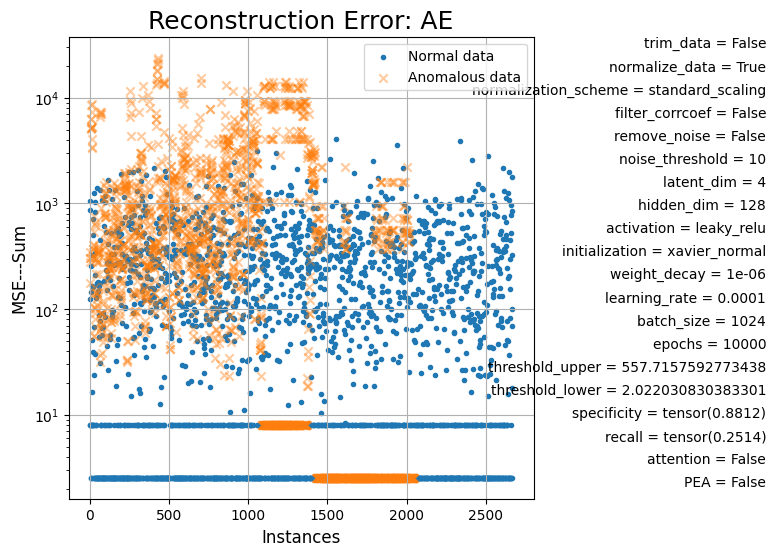

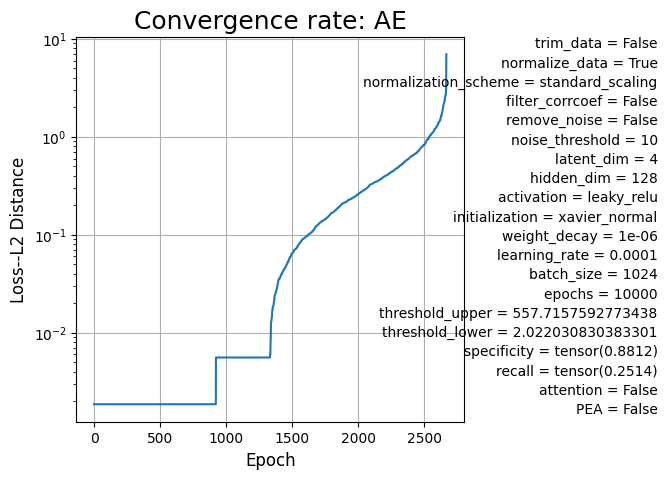

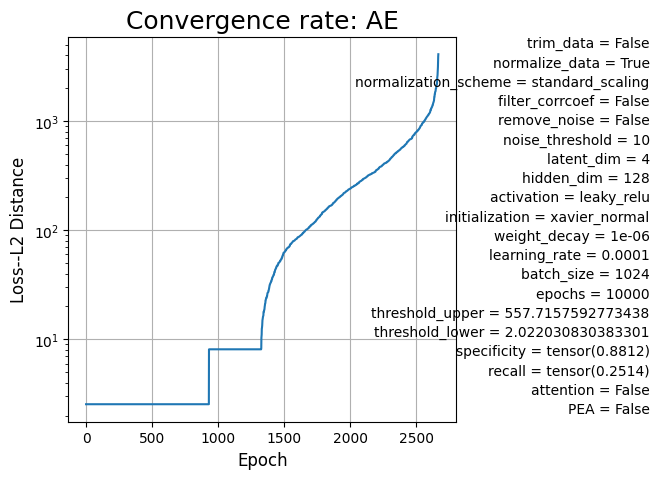

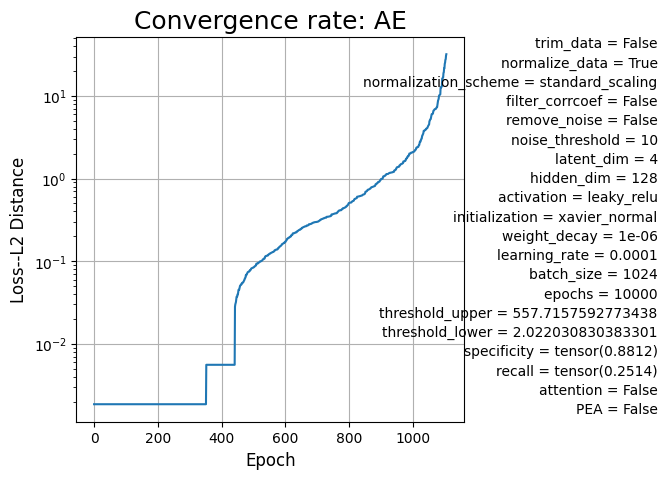

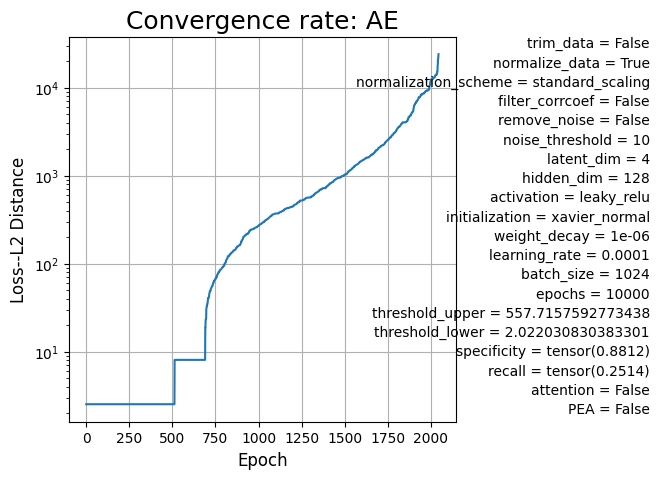

In [ ]:
visualize_loss(test_loss.detach().numpy(), attack_loss.detach().numpy(), model.name, save=False, **parameters)
sorted_loss_test, sorted_test_loss = torch.sort(torch.tensor(loss_test))[0], torch.sort(test_loss)[0]
sorted_loss_attack, sorted_attack_loss = torch.sort(torch.tensor(loss_attack))[0], torch.sort(attack_loss)[0]
visualize_convergence(sorted_loss_test, model.name, save=False, **parameters)
visualize_convergence(sorted_test_loss.detach(), model.name, save=False, **parameters)
visualize_convergence(sorted_loss_attack, model.name, save=False, **parameters)
visualize_convergence(sorted_attack_loss.detach(), model.name, save=False, **parameters)
sorted_loss, _ = torch.sort(torch.sum((model(train_data)-train_data)**2, dim=1, keepdim=False))
threshold = sorted_loss[math.floor(len(sorted_loss)*0.89)]
precision = torch.sum(torch.sum((model(test_data)-test_data)**2, dim=1) <= threshold) / len(test_data)
recall = torch.sum(torch.sum((model(anomalous_data)-anomalous_data)**2, dim=1) > threshold) / len(anomalous_data)
print(precision, recall)

In [ ]:
print(threshold)
count = 0
position = -1
b = BATCH_SIZE[0]
for _ in range(1000):
    idc = np.random.permutation(len(train_data))[0:b]
    context = train_data[idc].clone()
    chosen_attack_idc = np.random.randint(len(anomalous_data))
    context[position] = anomalous_data[chosen_attack_idc]
    if torch.sum((model(context)-context)**2, dim=1)[position] >= 0.65:
        count += 1
    """ chosen_attack_idc = np.random.randint(len(test_data))
    context = test_data[chosen_attack_idc].expand(1024, test_data.shape[-1])
    loss = torch.sum((model(context)-context)**2, dim=1)
    if loss[position] >= 5:
        #print(loss)
        count += 1 """
print("count: ", count)

print((torch.sum((model(anomalous_data)-anomalous_data)**2, dim=1) >= threshold).sum())
#print(torch.sum((model(anomalous_data)-anomalous_data)**2, dim=1))

#print(test_data[0:1])
#print(model(test_data[0:1]))
#print(torch.sum((test_data[0:1] - model(test_data[0:1]))**2))

#print(test_data[0])
#print(model(test_data)[0])


tensor(0.5376, grad_fn=<SelectBackward0>)
count:  352
tensor(768)


In [ ]:
if False:
    raw_data = np.loadtxt('../data/iiot_og.csv', dtype=str, delimiter=',')
    l = (raw_data.shape[-1])
    idc = [i for i in range(l) if i not in (0, 1, 2, 3, l-2)]
    raw_data = raw_data[:,idc]
    #np.savetxt('../data/iiot.csv', X=raw_data, delimiter=',', fmt='%s')
    
    idc = np.int32(raw_data[1:,-1]) == 1
    idc = np.append(True, idc)
    idc.shape
    idc.sum()
    np.savetxt('../data/iiot_attack_data.csv', X=raw_data[idc], delimiter=',', fmt='%s')
raw_data = np.loadtxt('../data/iiot.csv', dtype=str, delimiter=',', max_rows=1)

array(['"Mean"', '"Sport"', '"Dport"', '"SrcPkts"', '"DstPkts"',
       '"TotPkts"', '"DstBytes"', '"SrcBytes"', '"TotBytes"', '"SrcLoad"',
       '"DstLoad"', '"Load"', '"SrcRate"', '"DstRate"', '"Rate"',
       '"SrcLoss"', '"DstLoss"', '"Loss"', '"pLoss"', '"SrcJitter"',
       '"DstJitter"', '"SIntPkt"', '"DIntPkt"', '"Proto"', '"Dur"',
       '"TcpRtt"', '"IdleTime"', '"Sum"', '"Min"', '"Max"', '"sDSb"',
       '"sTtl"', '"dTtl"', '"sIpId"', '"dIpId"', '"SAppBytes"',
       '"DAppBytes"', '"TotAppByte"', '"SynAck"', '"RunTime"', '"sTos"',
       '"SrcJitAct"', '"DstJitAct"', '"Target"'], dtype='<U12')